In [4]:
import numpy as np
from CrossSections import Transfer_SigmaV, Transfer_sigma
from scipy.optimize import minimize


## Fits con Datos de Camila

In [5]:
#Import Data from Camila Correa
CamilaData_Fig6 = np.loadtxt('Data-Sets/Data_Fig6_Correa_2021.txt')

VelocityData = CamilaData_Fig6[:,0]
Velocity_16_Percentile = CamilaData_Fig6[:,1]
Velocity_84_Percentile = CamilaData_Fig6[:,2]
VelocityData_Err = ( (VelocityData - Velocity_16_Percentile) + (Velocity_84_Percentile - VelocityData) ) /2

CrossSectionData = CamilaData_Fig6[:,3]
CrossSectionData_16_Percentile = CamilaData_Fig6[:,4]
CrossSectionData_84_Percentile = CamilaData_Fig6[:,5]

CrossSectionData_Err = ((CrossSectionData - CrossSectionData_16_Percentile) + (CrossSectionData_84_Percentile - CrossSectionData) )/2


In [6]:
def CamilaTranser(v, M, m):
    alpha = 0.01
    w = 300*(M/10)*(10/m)
    sigma0T = 274.4*(alpha/0.01)**2*(m/10)*(10/M)**4
    return sigma0T*4*w**4/v**4 * (2*np.log(1 + v**2/(2*w**2)) - np.log(1 + v**2/w**2) )


# Define a chi square distribution to use as input in emcee
def compute_chi2(free_params, x=VelocityData, data=CrossSectionData, err=(VelocityData_Err, CrossSectionData_Err)):
    #Compute model
    M, m = free_params
    model = [CamilaTranser(x, M=M, m=m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y #+ chi2x


Fits for Figure 6

In [7]:

M_ini, m_ini = 1, 10
initial = [M_ini, m_ini]

soln = minimize(compute_chi2, initial, method='Nelder-Mead')

M_bf, m_bf = soln.x

print("Best Fit Parameters")
print('M = {0:.2f} MeV'.format(M_bf))
print('m = {0:.2f} GeV'.format(m_bf))
print("Chi-squared:", compute_chi2((M_bf, m_bf)))


Best Fit Parameters
M = 26.90 MeV
m = 112.78 GeV
Chi-squared: 22.40065400937851


Fits for Figure 7:

In [8]:
CamilaData_Fig7 = np.loadtxt('Data-Sets/Data_Fig7_Correa_2021.txt')
VelocityData = CamilaData_Fig7[:,0]
Velocity_16_Percentile = CamilaData_Fig7[:,1]
Velocity_84_Percentile = CamilaData_Fig7[:,2]
VelocityData_Err = ( (VelocityData - Velocity_16_Percentile) + (Velocity_84_Percentile - VelocityData) ) /2

CrossSectionData = CamilaData_Fig7[:,3]
CrossSectionData_16_Percentile = CamilaData_Fig7[:,4]
CrossSectionData_84_Percentile = CamilaData_Fig7[:,5]

CrossSectionData_Err = ((CrossSectionData - CrossSectionData_16_Percentile) + (CrossSectionData_84_Percentile - CrossSectionData) )/2


In [9]:

def Integrand_Camila_SigmaV(v, v0, M, m):
    return CamilaTranser(v, M, m)*v*np.exp(-0.5*v**2/v0**2)*v**2

from scipy.integrate import quad

def Camila_SigmaV(v0, M, m):
    sigma2_MB = v0**2*np.pi*(3*np.pi - 8)/np.pi
    vmax = 2*np.sqrt(sigma2_MB)

    Prefactor = 4*np.pi/((2*np.pi*v0**2)**1.5 * m)
    Integral = quad(Integrand_Camila_SigmaV, 0.1, vmax, args=(v0, M, m))[0]
    return Prefactor*Integral

# Define a chi square distribution to use as input in emcee
def compute_chi2(free_params, x=VelocityData, data=CrossSectionData, err=(VelocityData_Err, CrossSectionData_Err)):
    #Compute model
    M, m = free_params
    model = [Camila_SigmaV(x, M, m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y #+ chi2x

In [10]:
soln = minimize(compute_chi2, initial, method='Nelder-Mead')

M_bf, m_bf = soln.x

print("Best Fit Parameters")
print('M = {0:.2f} MeV'.format(M_bf))
print('m = {0:.2f} GeV'.format(m_bf))
print("Chi-squared:", compute_chi2((M_bf, m_bf)))

Best Fit Parameters
M = 8.65 MeV
m = 23.86 GeV
Chi-squared: 22.281826735887343


## Fits con datos de Yu

In [11]:
#for the plots
DwarfData = np.loadtxt('Data-Sets/DwarfDataPlot.csv', delimiter='\t')
Dwarf_x =     DwarfData[:,0]
Dwarf_y =     DwarfData[:,1]
Dwarf_Err_l = DwarfData[:,2]
Dwarf_Err_r = DwarfData[:,3]
Dwarf_Err_d = DwarfData[:,4]
Dwarf_Err_u = DwarfData[:,5]

GalaxyData = np.loadtxt('Data-Sets/GalaxyDataPlot.csv', delimiter='\t')
Galaxy_x = GalaxyData[:,0]
Galaxy_y = GalaxyData[:,1]
Galaxy_Err_l = GalaxyData[:,2]
Galaxy_Err_r = GalaxyData[:,3]
Galaxy_Err_d = GalaxyData[:,4]
Galaxy_Err_u = GalaxyData[:,5]

ClusterData = np.loadtxt('Data-Sets/ClusterDataPlot.csv', delimiter='\t')
Cluster_x = ClusterData[:,0]
Cluster_y = ClusterData[:,1]
Cluster_Err_l = ClusterData[:,2]
Cluster_Err_r = ClusterData[:,3]
Cluster_Err_d = ClusterData[:,4]
Cluster_Err_u = ClusterData[:,5]

# For the fit
OrderedData = np.loadtxt('Data-Sets/Datos_ordenados.csv')
x_data = OrderedData[:,0]
y_data = OrderedData[:,1]
err_x_data = OrderedData[:,2]
err_y_data = OrderedData[:,3]


In [12]:
def NormalTranser(v, M, m):
    alpha = 1/137
    w = 300*(M/10)*(10/m)
    sigma0T = 274.4*(alpha/0.01)**2*(m/10)*(10/M)**4
    return sigma0T*4*w**4/v**4 * (np.log(1 + v**2/(w**2)) - (v/w)**2/(1 + (v/w)**2) )

def Integrand_Normal_SigmaV(v, v0, M, m):
    return NormalTranser(v, M, m)*v*np.exp(-0.5*v**2/v0**2)*v**2

from scipy.integrate import quad

def Normal_SigmaV(v0, M, m):
    sigma2_MB = v0**2*np.pi*(3*np.pi - 8)/np.pi
    vmax = 2*np.sqrt(sigma2_MB)

    Prefactor = 4*np.pi/((2*np.pi*v0**2)**1.5 * m)
    Integral = quad(Integrand_Normal_SigmaV, 0.0, vmax, args=(v0, M, m))[0]
    return Prefactor*Integral

In [13]:

M_ini, m_ini = 10, 10
initial = [M_ini, m_ini]
bnds= [(1, 1000), (0.01, 1000)]

# Define a chi square distribution to use as input in emcee
def compute_chi2(free_params, x=x_data, data=y_data, err=(err_x_data, err_y_data)):
    #Compute model
    M, m = free_params
    model = [Normal_SigmaV(x, M=M, m=m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y + chi2x

soln = minimize(compute_chi2, initial, method='Nelder-Mead', bounds=bnds)

M_bf, m_bf = soln.x

print("Best Fit Parameters")
print('M = {0:.2f} MeV'.format(M_bf))
print('m = {0:.2f} GeV'.format(m_bf))
print("Chi-squared:", compute_chi2((M_bf, m_bf)))


Best Fit Parameters
M = 16.74 MeV
m = 9.96 GeV
Chi-squared: 1912472.709872893


Standard Cross Section but with Camila Data

In [14]:
def compute_chi2(free_params, x=VelocityData, data=CrossSectionData, err=(VelocityData_Err, CrossSectionData_Err)):
    #Compute model
    M, m = free_params
    model = [Normal_SigmaV(x, M=M, m=m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y #+ chi2x


M_ini, m_ini = 1, 10
initial = [M_ini, m_ini]


soln = minimize(compute_chi2, initial, method='Nelder-Mead')

M_bf, m_bf = soln.x

print("Best Fit Parameters")
print('M = {0:.2f} MeV'.format(M_bf))
print('m = {0:.2f} GeV'.format(m_bf))
print("Chi-squared:", compute_chi2((M_bf, m_bf)))

Best Fit Parameters
M = 8.80 MeV
m = 20.76 GeV
Chi-squared: 22.29372349282599


## Particle Physics Cross Section with Camila Data

Data From Dwarfs

In [15]:
#Import Data from Camila Correa
CamilaData_Fig6 = np.loadtxt('Data-Sets/Data_Fig6_Correa_2021.txt')

VelocityData = CamilaData_Fig6[:,0]
Velocity_16_Percentile = CamilaData_Fig6[:,1]
Velocity_84_Percentile = CamilaData_Fig6[:,2]
VelocityData_Err = ( (VelocityData - Velocity_16_Percentile) + (Velocity_84_Percentile - VelocityData) ) /2

CrossSectionData = CamilaData_Fig6[:,3]
CrossSectionData_16_Percentile = CamilaData_Fig6[:,4]
CrossSectionData_84_Percentile = CamilaData_Fig6[:,5]

CrossSectionData_Err = ((CrossSectionData - CrossSectionData_16_Percentile) + (CrossSectionData_84_Percentile - CrossSectionData) )/2

In [16]:
# Define a chi square distribution to use as input in emcee
def compute_chi2(free_params, x=VelocityData, data=CrossSectionData, err=(VelocityData_Err, CrossSectionData_Err)):
    #Compute model
    M, m = free_params
    model = [Transfer_sigma(x, g=0.3, M=M, m=m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y #+ chi2x


M_ini, m_ini = 10, 10
initial = [M_ini, m_ini]
bnds= [(1, 1000), (.01, 1000)]


soln = minimize(compute_chi2, initial, method='Nelder-Mead', bounds=bnds)

M_bf, m_bf = soln.x

print("Best Fit Parameters")
print('M = {0:.2f} MeV'.format(M_bf))
print('m = {0:.2f} GeV'.format(m_bf))
print("Chi-squared:", compute_chi2((M_bf, m_bf)))

Best Fit Parameters
M = 9.97 MeV
m = 10.59 GeV
Chi-squared: 268.4677777740588


Data From clusters

In [17]:
CamilaData_Fig7 = np.loadtxt('Data-Sets/Data_Fig7_Correa_2021.txt')
VelocityData = CamilaData_Fig7[:,0]
Velocity_16_Percentile = CamilaData_Fig7[:,1]
Velocity_84_Percentile = CamilaData_Fig7[:,2]
VelocityData_Err = ( (VelocityData - Velocity_16_Percentile) + (Velocity_84_Percentile - VelocityData) ) /2

CrossSectionData = CamilaData_Fig7[:,3]
CrossSectionData_16_Percentile = CamilaData_Fig7[:,4]
CrossSectionData_84_Percentile = CamilaData_Fig7[:,5]

CrossSectionData_Err = ((CrossSectionData - CrossSectionData_16_Percentile) + (CrossSectionData_84_Percentile - CrossSectionData) )/2


In [18]:
# Define a chi square distribution to use as input in emcee
def compute_chi2(free_params, x=VelocityData, data=CrossSectionData, err=(VelocityData_Err, CrossSectionData_Err)):
    #Compute model
    M, m = free_params
    model = [Transfer_SigmaV(x, g=0.3, M=M, m=m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y #+ chi2x


M_ini, m_ini = 10, 10
initial = [M_ini, m_ini]
bnds= [(1, 1000), (.01, 1000)]


soln = minimize(compute_chi2, initial, method='Nelder-Mead', bounds=bnds)

M_bf, m_bf = soln.x

print("Best Fit Parameters")
print('M = {0:.2f} MeV'.format(M_bf))
print('m = {0:.2f} GeV'.format(m_bf))
print("Chi-squared:", compute_chi2((M_bf, m_bf)))

d:\Nicolás\Documents\Research\Pre-Prints\Leptophilic-Atlas\Leptophilic-Atlas-Repo\Leptophilic-Atlas-Repo\CrossSections.py:70: RuntimeWarning: invalid value encountered in log
  sigma_t = Prefactor*( (s*v**2*(2*s + 3*M**2)+2*(M**2 + 2*m**2)**2)/(2*M**2*(M**2+s*v**2)) - (M**2 + s)/(s*v**2)*np.log(1 + s*v**2/M**2) )
d:\Nicolás\Documents\Research\Pre-Prints\Leptophilic-Atlas\Leptophilic-Atlas-Repo\Leptophilic-Atlas-Repo\CrossSections.py:72: RuntimeWarning: invalid value encountered in log
  sigma_st = -Prefactor/2*( (16*m**2+2*M**2+ 3*s*v**2)/(s-M**2) - (4*m**2 + 2*m**2*(4*M**2+3*s*v**2+s ) + (M**2+s*v**2)**2 )/(s*v**2*(s-M**2))*np.log(1 + s*v**2/M**2) )
d:\Nicolás\Documents\Research\Pre-Prints\Leptophilic-Atlas\Leptophilic-Atlas-Repo\Leptophilic-Atlas-Repo\CrossSections.py:62: RuntimeWarning: invalid value encountered in log
  return  fc*Prefactor*(Term1 + LogTerm1*np.log(1 + s*v**2/M**2) )
d:\Nicolás\Documents\Research\Pre-Prints\Leptophilic-Atlas\Leptophilic-Atlas-Repo\Leptophilic-Atlas

Best Fit Parameters
M = 10.00 MeV
m = 10.00 GeV
Chi-squared: nan


## Plots

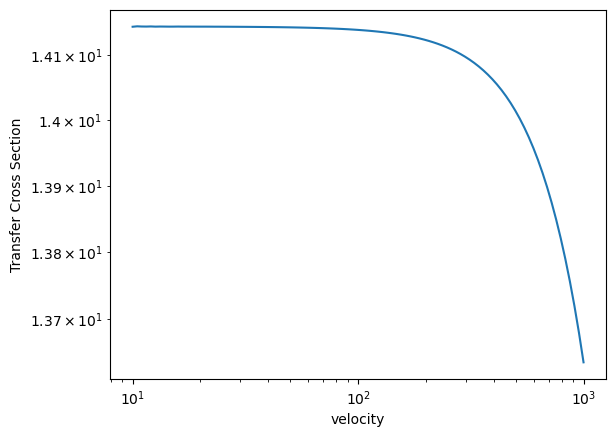

In [2]:
import matplotlib.pyplot as plt 
v_array = np.logspace(1, 3, 100)
crossSection_array = [Transfer_sigma(v) for v in v_array]


plt.plot(v_array, crossSection_array)


plt.xscale('log')
plt.yscale('log')
plt.ylabel('Transfer Cross Section')
plt.xlabel('velocity')
plt.show()
